# This notebook handles ingestion of stocks data to feature store

In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-05-23 10:55:46,515 [info] loaded project stocks from MLRun DB


> <b> Steps </b>
> * [Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json](#Creating-mlrun-function-that-reads-stocks-from-yahoo_fin-and-returning-record-oriented-json)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json
similar to ingest_stocks, we collect the data from within the feature-set graph. <br>
event sent to graph is real-time configuration.

In [3]:
STREAM_SHARDS = 1 # NO. of input stream shard

In [4]:
# serving function configuration
SERVING_FUNCTION_RESPONSE = 'SYNC'
MIN_REPLICAS = 1 # serving function minimum replicas
MAX_REPLICAS = 1 # serving function maximum replicas
SERVING_PROCESSING_TIME = 1 # time for the serving function to sleep
WORKER_AVAILIBALITY_TIMEOUT = 100
INGRESS_TIMEOUT = 150
USE_GPU = False # whether the serving function will use GPU (if true - REMOTE_SCALE_RANGE will determine the consumption)

In [5]:
# RemoteStep configuration
REMOTE_STEP_WORKERS = 1
MAX_IN_FLIGHT = 1  # how many simulteneous events on each worker in the serving function
REMOTE_STEP_HTTP_TIMEOUT = 150
STOREY_QUEUE_SIZE = 8
WINDOW_ACK = (STOREY_QUEUE_SIZE+MAX_IN_FLIGHT)*STREAM_SHARDS

In [6]:
import nuclio
import mlrun

model_location = 'https://iguazio-sample-data.s3.amazonaws.com/models/model.pt'
scaled_function = mlrun.import_function('hub://sentiment_analysis_serving')
scaled_function.spec.min_replicas = MIN_REPLICAS
scaled_function.spec.max_replicas = MAX_REPLICAS
scaled_function.add_model('sentiment_analysis_model', model_path=model_location, class_name='SentimentClassifierServing')

scaled_function.with_http(workers=REMOTE_STEP_WORKERS, gateway_timeout=INGRESS_TIMEOUT, worker_timeout=WORKER_AVAILIBALITY_TIMEOUT)

env_vars = {"SERVING_FUNCTION_TIME_TO_SLEEP": SERVING_PROCESSING_TIME}

scaled_function.set_envs(env_vars)
scaled_function.spec.readiness_timeout = 300
address = scaled_function.deploy()

> 2022-05-23 10:55:51,226 [info] Starting remote function deploy
2022-05-23 10:55:51  (info) Deploying function
2022-05-23 10:55:51  (info) Building
2022-05-23 10:55:51  (info) Staging files and preparing base images
2022-05-23 10:55:51  (info) Building processor image
2022-05-23 10:57:46  (info) Build complete
2022-05-23 10:59:16  (info) Function deploy complete
> 2022-05-23 10:59:17,574 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-avia-sentiment-analysis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-avia-sentiment-analysis-serving-stocks-avia.default-tenant.app.dev39.lab.iguazeng.com/']}


In [7]:
#mlrun: start-code

import yahoo_fin.stock_info as si
import yahoo_fin.news as ynews
from dateutil import parser
import pandas as pd 
import json
import requests
from storey import MapClass, Event
import string
import mlrun

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def get_news(event):
    '''
    event: dict with the following keys:
    n_stocks - how many stocks to collect
    '''
    tickers = si.tickers_sp500()[:event['n_stocks']]
    tickers_news = []
    for ticker in tickers:
        news = ynews.get_yf_rss(ticker=ticker)
        news_df = pd.DataFrame(news)
        df_copy = news_df[['title','summary','link','published']].copy()
        df_copy['ticker'] = ticker
        df_copy['Datetime'] = df_copy['published'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d %H:%M:%S'))
        df_copy['summary'] = df_copy['summary'].apply(lambda x:remove_punctuation(x))
        df_copy['title'] = df_copy['title'].apply(lambda x:remove_punctuation(x))
        tickers_news.append(df_copy)
    df = pd.concat(tickers_news).reset_index(drop=True)
    return json.loads(df.to_json(orient='records'))

class sentiment_analysis(MapClass):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        model_location = 'https://iguazio-sample-data.s3.amazonaws.com/models/model.pt'
        fn = mlrun.import_function('hub://sentiment_analysis_serving')
        fn.add_model('sentiment_analysis_model', model_path=model_location, class_name='SentimentClassifierServing')
        self.sentiment_model_endpoint = fn.deploy()
        
    def do(self,event):
        event.body['sentiment'] = json.loads(requests.put(self.sentiment_model_endpoint + "/v2/models/sentiment_analysis_model/predict",
                                                     json=json.dumps({'inputs':[event.body['summary']]})).text)['outputs'][0]/2 # so it'll be 0 for neg, 0.5 for neutral and 1 for pos
        
        return Event(event.body,key=event.body['ticker'],time=event.body['Datetime'])
    
#mlrun: end-code

## Creating a feature set and declaring the graph

In [8]:
fn = mlrun.import_function('hub://sentiment_analysis_serving')
mod = mlrun.function_to_module(fn,workdir='./')

In [9]:
mod.SentimentClassifierServing

tmpvbd4574z.SentimentClassifierServing

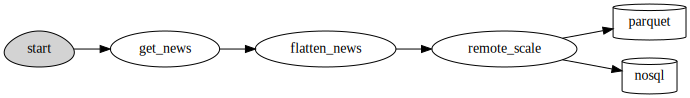

In [13]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si

# creating feature set
news_set = fstore.FeatureSet("stocks_news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
# n_tickers = 4

news_set.graph\
    .to(name='get_news',handler='get_news')\
    .to("storey.steps.Flatten", name="flatten_news")\
    .to(RemoteStep(name="remote_scale", url=address, method="POST", max_in_flight=MAX_IN_FLIGHT,timeout=REMOTE_STEP_HTTP_TIMEOUT)) \
#     .to(class_name = mod.SentimentClassifierServing() ,name= "sentiment_analysis_model", model_path='https://iguazio-sample-data.s3.amazonaws.com/models/model.pt',
#         function='')\


#     .to("sentiment_analysis", "sentiment_analysis_model",full_event=True)\

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [14]:
# ingesting dummy (A MUST) 
import os
import datetime

name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(news_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'n_stocks':1}))

> 2022-05-23 11:03:01,011 [error] Pushing error to error stream: For event Event(id=0b99c55be1d044b3b392aef693ec5585-0000, key=['avia'], time=2022-05-23 11:02:54, body={'title': 'Nvidia Macy’s Zoom Costco Snowflake and Other Stocks to Watch This Week', 'summary': 'Earnings this week will include Zoom Best Buy Toll Brothers Nvidia Snowflake Alibaba Costco Dell and Macy’s Plus FOMC minutes durable goods and income and outlays data', 'link': 'https://finance.yahoo.com/m/cce7b005-6192-3999-8a8b-32dd96c75429/nvidia%2C-macy%E2%80%99s%2C-zoom%2C-costco%2C.html?.tsrc=rss', 'published': 'Mon, 23 May 2022 00:23:00 +0000', 'ticker': 'A', 'Datetime': '2022-05-23 00:23:00'}), RemoteStep remote_scale got an unexpected response status 400: b'Exception: Expected key "inputs" in request body'
Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-avia/lib/python3.7/site-packages/storey/flow.py", line 167, in _do_and_recover
    return await self._do(event)
  File "/User/.pythonlibs/jupyte

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f9a60dabb50>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x7f99b362a2f0>, 351580.941085256)]']
connector: <aiohttp.connector.TCPConnector object at 0x7f99c0e2c590>


> 2022-05-23 11:03:02,673 [error] Pushing error to error stream: For event Event(id=2065940c97b147d38dced6310210e454-0000, key=['avia'], time=2022-05-23 11:02:54, body={'title': 'Nvidia Macy’s Zoom Costco Snowflake and Other Stocks to Watch This Week', 'summary': 'Earnings this week will include Zoom Best Buy Toll Brothers Nvidia Snowflake Alibaba Costco Dell and Macy’s Plus FOMC minutes durable goods and income and outlays data', 'link': 'https://finance.yahoo.com/m/cce7b005-6192-3999-8a8b-32dd96c75429/nvidia%2C-macy%E2%80%99s%2C-zoom%2C-costco%2C.html?.tsrc=rss', 'published': 'Mon, 23 May 2022 00:23:00 +0000', 'ticker': 'A', 'Datetime': '2022-05-23 00:23:00'}), RemoteStep remote_scale got an unexpected response status 400: b'Exception: Expected key "inputs" in request body'
Traceback (most recent call last):
  File "/User/.pythonlibs/jupyter-avia/lib/python3.7/site-packages/storey/flow.py", line 167, in _do_and_recover
    return await self._do(event)
  File "/User/.pythonlibs/jupyte

""


In [ ]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin','graphviz'])
function.spec.readiness_timeout=100000

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [ ]:
# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

## Testing ingestion service

In [ ]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':4})
t.text

## Creating scheduled mlrun job to invoke our function every time delta

In [ ]:
os.makedirs('src',exist_ok=True)

In [ ]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['news'],
                                     'Datetime': now,
                                     'n_stocks':4})

In [ ]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint}, schedule='0 8 * * *')